In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import sklearn
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense
import tensorflow as tf
tf.enable_eager_execution()
from sklearn.model_selection import TimeSeriesSplit


In [55]:
from google.colab import drive
import sys


drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Global Variables 

In [0]:
window_size = 5
batch_size = 60

## Loading Data 

In [0]:
apple = pd.read_csv("/content/drive/My Drive/Datasets/AAPL_dataframe.csv")

In [58]:
apple.head()

,Date,Open,High,Low,Close,Volume,Count
0,20150126,103.38,105.06,103.38,104.24,522192,199665
1,20150127,104.35,106.98,100.15,106.00,883443,373793
2,20150128,106.08,109.54,104.99,106.31,1346702,595026
3,20150129,106.29,109.61,105.73,109.36,767892,355772
4,20150130,109.22,110.23,107.33,107.72,757564,325884


In [59]:
print(apple.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date      1258 non-null int64
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null int64
Count     1258 non-null int64
dtypes: float64(4), int64(3)
memory usage: 68.9 KB
None


In [0]:
apple["Date"] = pd.to_datetime(apple['Date'], format="%Y%m%d")
#apple.set_index('Date', inplace=True)
df = apple.copy(deep = False).drop(columns=["Date","Count"])

In [61]:
print(apple.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
Date      1258 non-null datetime64[ns]
Open      1258 non-null float64
High      1258 non-null float64
Low       1258 non-null float64
Close     1258 non-null float64
Volume    1258 non-null int64
Count     1258 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 68.9 KB
None
     Open    High     Low   Close   Volume
0  103.38  105.06  103.38  104.24   522192
1  104.35  106.98  100.15  106.00   883443
2  106.08  109.54  104.99  106.31  1346702
3  106.29  109.61  105.73  109.36   767892
4  109.22  110.23  107.33  107.72   757564


## Univariate Time Series 

A univariate time series, as the name suggests, is a series with a single time-dependent variable.

## Multivariate Time Series

A Multivariate time series has more than one time-dependent variable. Each variable depends not only on its past values but also has some dependency on other variables. 

### Reflection

Since the stock price prediction will be based upon various different technical indicators and features of a given stock. The modeling should be based on a multi-variate time series analysis.

## LABELING DATA

Choice of labeling has many options to move on with. The selection depends on the considerations and limitations and objectives of the analysis. 

I believe in the first stage or in any stage it would be too hard of a task to predict single point precisely in the future. If we account for the stochasticity of the stock market, aiming for precise prediction of price would not be a reasonable objective. We should aim to identify the trend.  Therefore, I will take a rolling window and take the mean of the window to create the label data. 


This approach is a single step approach. Because we are trying to predict a single value into the future rather than multiple values. 

### EXPANDING TRAIN AND TEST SPLIT

In order better assess the future and not get biased and rely too much on the past, it would be a better idea to implement a train and test split on the rolling basis. Therefore, we can asses more clearly how generalizable our model can be. 



In [62]:
def expanding_train_test_split(df,n_splits=5,val_portion =.1):
  tscv = TimeSeriesSplit()
  print(tscv)

  TimeSeriesSplit(max_train_size=None, n_splits=n_splits)

  training_sets = []
  val_sets = []
  test_sets = []

  for train_index, test_index in tscv.split(df):
    total_training_data = df.loc[train_index,:]
    length_total_training_data = len(total_training_data)
    val_split_index = length_total_training_data-int(length_total_training_data*val_portion)
    
    training_data = total_training_data.loc[:val_split_index,:]
    val_data = total_training_data.loc[val_split_index:,:]

    training_sets.append(training_data)
    val_sets.append(val_data)
    test_sets.append(df.loc[test_index,:])

  return training_sets,val_sets,test_sets

training_sets,val_sets,test_sets = expanding_train_test_split(df)


TimeSeriesSplit(max_train_size=None, n_splits=5)


### Model Types

#### Single Step Model
In a single step model, the model needs to learn to predict a single future value.

#### Multi Step Model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values

In [0]:
## Filling with mean will help us preserve the nature of standardization. 
## Since these values will not be used it is not what value they have. 
## I just wanted to get rid of NaN for the standardization process


def label_datasets(dataset,column_selection: str,window_size: int = window_size, target_column_name = "target"):
  
  def create_labels(df, column_selection: str,window_size: int, target_column_name = "target"):
    df[target_column_name] = df[column_selection].rolling(window_size).mean()
    df[target_column_name] = df[target_column_name].fillna(df[target_column_name].mean())
    return df

  for i in range(len(dataset)):
    dataset[i] = create_labels(dataset[i],column_selection=column_selection, window_size=window_size, target_column_name = target_column_name)

  return dataset
  

training_sets = label_datasets(training_sets,column_selection = "Close",window_size = window_size)
val_sets = label_datasets(val_sets,column_selection = "Close",window_size = window_size)
test_sets = label_datasets(test_sets,column_selection = "Close",window_size = window_size)

In [89]:
standardization_cache["window_1"]["mean"]["target"]

113.10049735449732

## Standardization 

We need to apply standardization to validation and test data with statistical values of our training. Otherwise, we would harm the integrity of the testing process.

Another option would be standardize within windows therefore avoiding the gap between initial and late prices. 

https://www.datacamp.com/community/tutorials/lstm-python-stock-market 

In [0]:
def standardize_data(training_sets,val_sets,test_sets):
  
  window_mean_std = {}

  standardized_training_sets = []
  standardized_val_sets = []
  standardized_test_sets = []

  if len(training_sets) == len(test_sets):
    for i in range(len(training_sets)):
      
      data_mean = training_sets[i].mean(axis=0)
      data_std = training_sets[i].std(axis=0)

      window = {}
      window["mean"] = data_mean
      window["std"] = data_std

      window_mean_std["window_"+str(i+1)] = window

      standardized_training_set = (training_sets[i]-data_mean)/data_std
      standardized_val_set = (val_sets[i]-data_mean)/data_std
      standardized_test_set = (test_sets[i]-data_mean)/data_std

      standardized_training_sets.append(standardized_training_set)
      standardized_val_sets.append(standardized_val_set)
      standardized_test_sets.append(standardized_test_set)

  else:
    print("Training and test set length does not match!")
  
  return standardized_training_sets,standardized_val_sets,standardized_test_sets,window_mean_std


In [0]:
def inverse_standardization(data,standardization_cache,window_no,column_name):
  key = "window_"+str(window_no)
  window = standardization_cache[key]
  mean = window["mean"][column_name]
  std = window["std"][column_name]
  return (data*std)+mean

In [0]:
train_sets, val_sets, test_tests, standardization_cache = standardize_data(training_sets,val_sets,test_sets)


### Splitting Features and Labels in Datasets

Split is necessary for the windowing process. Features have a multivariate nature while labels are univariate, therefore, I will implement different functions to window those dataset. 

In [67]:
print("Columns currently available in the dataframes:\n",train_sets[0].columns)

Columns currently available in the dataframes:
 Index(['Open', 'High', 'Low', 'Close', 'Volume', 'target'], dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f49671f9160>,
      dtype=object)

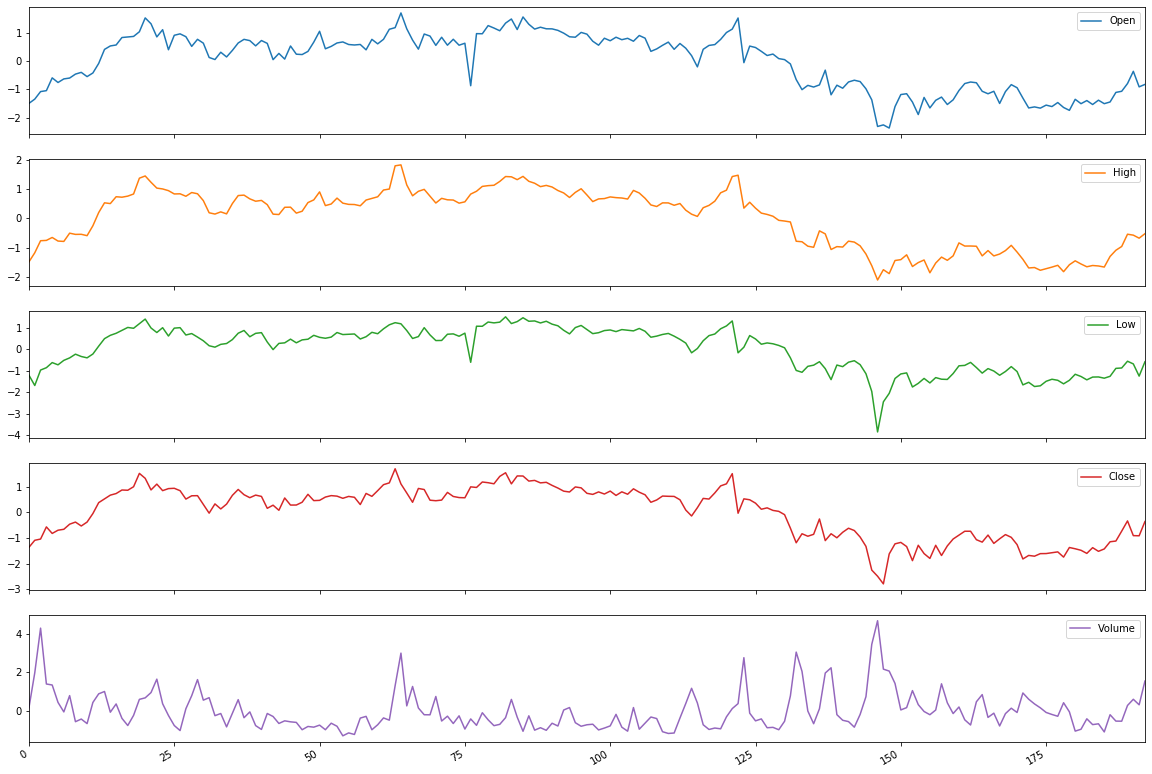

In [68]:
label_column = ["target"]
feature_columns = [x for x in train_sets[0].columns if x not in label_column]
train_sets[0][feature_columns].plot(subplots=True, figsize = (20,15))

In [0]:
def split_features_and_labels(datasets, feature_columns,label_column):
  data_dict = {}
  feature_data = []
  label_data = []
  for i in range(len(datasets)):
    feature_data.append(datasets[i].loc[:,feature_columns])
    label_data.append(datasets[i].loc[:,label_column])
  
  data_dict["X"] = feature_data
  data_dict["y"] = label_data
  
  return data_dict

In [0]:
train_dict = split_features_and_labels(train_sets, feature_columns, label_column)
val_dict = split_features_and_labels(val_sets, feature_columns, label_column)
test_dict =  split_features_and_labels(test_tests, feature_columns, label_column)

In [0]:
def window_feature_datasets(datasets, window_size):
  def window_features(features_data,window_size):
    data = []
    end_index = len(features_data) - window_size + 1
    for i in range(0, end_index):
      indices = range(i, i + window_size)
      data.append(features_data.values[indices])

    return np.array(data)
    
  for i in range(len(datasets)):
    datasets[i] = window_features(datasets[i],window_size)

  return np.array(datasets)


### 

def window_labels_datasets(datasets, window_size): 
  def window_labels(label_data,window_size):
    data = []
    for i in range(window_size-1,len(label_data)):
      data.append(label_data.values[i])
    
    return np.array(data)
    
  for i in range(len(datasets)):
    datasets[i] = window_labels(datasets[i],window_size)

  return np.array(datasets)

def process_data_dict(data_dict, window_size):
  feature_datasets = data_dict["X"]
  label_datasets = data_dict["y"]

  data_dict["X"] = window_feature_datasets(feature_datasets, window_size)
  data_dict["y"] = window_labels_datasets(label_datasets, window_size)

  return data_dict


In [0]:
train_dict = process_data_dict(train_dict,window_size=window_size)
val_dict = process_data_dict(val_dict,window_size=window_size)
test_dict = process_data_dict(test_dict,window_size=window_size)


In [73]:
## (#_windows, window_length, features)
print(train_dict["X"][0].shape)
## (#_windows, outcome)
print(train_dict["y"][0].shape)

## (#_windows, window_length, features)
print(val_dict["X"][0].shape)
## (#_windows, outcome)
print(val_dict["y"][0].shape)

(189, 5, 5)
(189, 1)
(17, 5, 5)
(17, 1)


## Batching Data 

#### Batch Size determines how many windows are going to be feed into the model together. It is important to catch seasonality with batchsize so that the patterns can be recognized better. 

In [0]:
def batch_data(data, batch_size):
  if data["X"].shape[0] == data["y"].shape[0]:
    n_iterations = data["X"].shape[0]
    batched_sets = []
    
    for i in range(n_iterations):
      slices = tf.data.Dataset.from_tensor_slices((data["X"][i], data["y"][i]))
      batched_data = slices.cache().batch(batch_size).repeat()
      batched_sets.append(batched_data)

    return batched_sets

  else: 
    return print("Data shapes don't match")

In [75]:
train_batch = batch_data(train_dict,10)
val_batch = batch_data(val_dict,2)
test_batch = batch_data(test_dict,50)

print("Dataset: ", train_batch)
print("Dataset subset: ", train_batch[1])

Dataset:  [<DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>, <DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>, <DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>, <DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>, <DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>]
Dataset subset:  <DatasetV1Adapter shapes: ((?, 5, 5), (?, 1)), types: (tf.float64, tf.float64)>


## Model Implementation

In [0]:
train_data = train_batch[0]
val_data = val_batch[0]
input_shape = train_dict["X"][0].shape[-2:]
epochs =  10

In [77]:
def build_model():  

  model = Sequential()

  model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

# Fitting the RNN to the Training set

def fit_model(model,train_dict, val_dict ,window_number,epochs, batch_size, verbose):
  ## Window number: A rolling window has been used for the generalization purposes. 
  ##                Window number determines which of the expanding windows to train the model.

  return model.fit(train_dict["X"][window_number], train_dict["y"][window_number],
                   epochs = epochs, batch_size = batch_size, 
                   validation_data=(val_dict["X"][window_number],val_dict["y"][window_number]),
                   verbose = verbose)


model = build_model()

history = fit_model(model,train_dict, val_dict ,window_number = 0 ,epochs = 50 , batch_size = 50 , verbose =2)


Train on 189 samples, validate on 17 samples
Epoch 1/50
189/189 - 7s - loss: 1.0026 - val_loss: 0.3266
Epoch 2/50
189/189 - 0s - loss: 0.9370 - val_loss: 0.3026
Epoch 3/50
189/189 - 0s - loss: 0.8108 - val_loss: 0.2544
Epoch 4/50
189/189 - 0s - loss: 0.5990 - val_loss: 0.1541
Epoch 5/50
189/189 - 0s - loss: 0.2599 - val_loss: 0.0679
Epoch 6/50
189/189 - 0s - loss: 0.1307 - val_loss: 0.1543
Epoch 7/50
189/189 - 0s - loss: 0.1443 - val_loss: 0.1312
Epoch 8/50
189/189 - 0s - loss: 0.0739 - val_loss: 0.1573
Epoch 9/50
189/189 - 0s - loss: 0.0841 - val_loss: 0.1518
Epoch 10/50
189/189 - 0s - loss: 0.0778 - val_loss: 0.1094
Epoch 11/50
189/189 - 0s - loss: 0.0684 - val_loss: 0.0821
Epoch 12/50
189/189 - 0s - loss: 0.0567 - val_loss: 0.0859
Epoch 13/50
189/189 - 0s - loss: 0.0645 - val_loss: 0.0747
Epoch 14/50
189/189 - 0s - loss: 0.0498 - val_loss: 0.0625
Epoch 15/50
189/189 - 0s - loss: 0.0463 - val_loss: 0.0595
Epoch 16/50
189/189 - 0s - loss: 0.0531 - val_loss: 0.0604
Epoch 17/50
189/189 

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

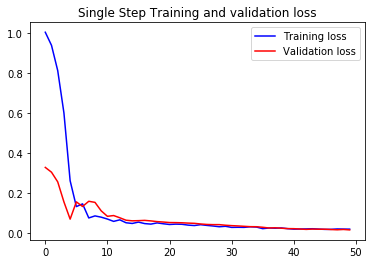

In [79]:
plot_train_history(history,
                   'Single Step Training and validation loss')

### Visualization of Results

In [0]:
pred = inverse_standardization(model.predict(val_dict["X"][0]),standardization_cache=standardization_cache,window_no = 1, column_name="target")
actual = inverse_standardization(val_dict["y"][0], standardization_cache=standardization_cache,window_no = 1, column_name="target")

In [0]:
def plot_pred_vs_real(actual,pred):
  plt.figure(figsize=(14,5))
  marker = ['.-', 'rx', 'go']

  plt.plot(actual, marker[0], color = 'red', label = 'True Future')
  plt.plot(pred, marker[1], color = 'blue', label = 'Model Prediction')
  plt.title('Stock Price 5-day Average Prediction')
  plt.xlabel('Time')
  plt.ylabel('Apple Stock Price')
  plt.legend()
  plt.show()

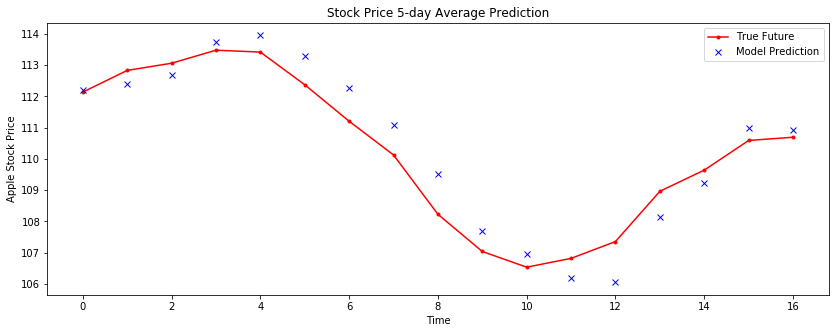

In [112]:
plot_pred_vs_real(actual,pred)

## Things To Do for Improvement

- To deal with overfitting:

    - Dropout
    - CNN layer
    - More data 
    - Feature Engineering

- Feature selection(with Lasso or XGBoost)
- Hyperparameter tuning 
    - Learning Rate
    - Batch size
    - Window size
    - Steps per epoch 
    - Different loss function and metrics to assess 

- Neural Network architecture (Layer Size, Hidden Unit Selection)
- Try different time intervals(Daily and hourly)
- Search if transfer learning can be implemented from existing pattern recognition architectures for LSTM and filters for CNN 

- Add features to model related with market sentiment and global outlook
